# Discovering Entrainment Velocity from LES


The aim of this notebook is to use the PySR library to discover the form and coefficents of entrainment velocity. Entrainment velocity is currently defined as:

$$\frac{dh}{dt} = A\frac{\overline{w'b'_{sfc}}}{\frac{g}{\theta_0}\Delta\theta_\rho} + \overline{w_h}$$

where
- A is a constant (typically between .2 or .4)
- $\overline{w'b'_{sfc}}$ is buoyancy flux and is ```b_flux``` at zh=0 in the simulations
- g is a constant (acceleration due to gravity)
- $\theta_0$ is a constant (300 K)
- $\Delta\theta_\rho$ is the change in $\theta$ at the inversion layer
- $\overline{w_h}$ is large scale vertical velocity (like subsidence), and is set to 0 in the LES used

# Importing libraries and making functions

In [1]:
import pysr
from pysr import PySRRegressor

import xarray as xr
import netCDF4 as nc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from glob import glob
import seaborn as sns

import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
folder_path = '/home/laurapong321/leap_24/les_sim_2'

#getting the correct dimension values
nc_test1 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_I.nc'), mode='r')
z_256 = nc_test1.variables['z'][:]
zh_257 = nc_test1.variables['zh'][:]
t_120 = nc_test1.variables['time'][:]
#rewrite this code but using 'Ug2Q010_IV.nc' instead
nc_test2 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_IV.nc'), mode='r')
z_384 = nc_test2.variables['z'][:]
zh_385 = nc_test2.variables['zh'][:]
t_90 = nc_test2.variables['time'][:]
print(len(z_256), len(zh_257), len(t_120), len(z_384), len(zh_385), len(t_90))

256 257 120 384 385 90


In [3]:
def read_data(filepath):
    """
    Reads in each dataset and returns an xarray dataset
    """

    #reading in each group as its own xarray dataset
    ds_thm = xr.open_dataset(f"{filepath}",
                             decode_times=False, group="thermo")
    ds_bud = xr.open_dataset(f"{filepath}",
                            decode_times=False, group="budget")
    ds_def = xr.open_dataset(f"{filepath}", 
                             decode_times=False, group="default")
    
    #merging all xarray datasets
    ds = xr.merge([ds_thm, ds_bud, ds_def], join="inner")

    #assigning the correct coordinates for each LES depending
    #on the length and size of the LES
    if len(ds.time) == 90:
        ds = ds.assign_coords({"time": t_90}).swap_dims({"time":"time"})
    elif len(ds.time) == 120:
        ds = ds.assign_coords({"time": t_120}).swap_dims({"time":"time"})

    if len(ds.z) == 256:
        ds = ds.assign_coords({"z": z_256}).swap_dims({"z":"z"})
    elif len(ds.z) == 384:
        ds = ds.assign_coords({"z": z_384}).swap_dims({"z":"z"})

    if len(ds.zh) == 257:
        ds = ds.assign_coords({"zh": zh_257}).swap_dims({"zh":"zh"})
    elif len(ds.zh) == 385:
        ds = ds.assign_coords({"zh": zh_385}).swap_dims({"zh":"zh"})

 
    return ds

In [4]:
def find_jump(ds, filter_num=.001):
    """
    Parameters:
    - ds: xarray dataset, desried LES
    - filter_num: threshold  that is close to 0 for filtering through the data
    
    Returns: a dataset with the new variable
     "th_jump," in the time dimension
    """
    #making an array to store all the values of th_jump
    th_jump = np.array([])

    #subsetting for only the th (potential temp) variable
    ds_jump = ds.copy()
    ds_jump = ds_jump[["th"]]

    #looping through every time and calculating th_jump
    for i in range(len(ds_jump.time)):

        #calculating the second derivate using np.diff
        #(central diff)
        diff_df = np.diff(ds_jump.isel(time=i).th, n=2)

        #putting the array into a dataframe to preserve the index
        #(height var)
        diff_df = pd.DataFrame(diff_df)
        diff_df = diff_df.reset_index()
        diff_df = diff_df.rename(columns={"index": "z", 0:"sec_der"})

        #chopping off the beginning and end of the df
        diff_df = diff_df.iloc[50:350]

        #filtering the df to only select for heights
        #with big enough second derivatives
        diff_df = diff_df[np.abs(diff_df["sec_der"]) >= filter_num]

        if len(diff_df) == 0:
            return "Try different filter num, everything filtered out"
        

        #getting the heights
        if (diff_df.z.iloc[1] - diff_df.z.iloc[0]) <= 1:
            min_z = diff_df.z.iloc[0]
        #making sure to cut off tails of sparse values
        else:
            j = 1
            while (diff_df.z.iloc[j+1] - diff_df.z.iloc[j]) >= 2:
                min_z = diff_df.z.iloc[j]
                j+=1

        
        if (diff_df.z.iloc[-1] - diff_df.z.iloc[-2]) <= 1:
            max_z = diff_df.z.iloc[-1]
        #making sure to cut off tails of sparse values
        else:
            j=-2
            while (diff_df.z.iloc[j] - diff_df.z.iloc[j-1]) >=2:
                max_z = diff_df.z.iloc[j]
                j-=1
        
        #calc th_jump
        jump = (ds_jump.isel(time=i, z=max_z).th.values - ds_jump.isel(time=i, z=min_z).th.values)
        if jump < 0:
            return f"Error in calculation: th_jump at time={i} is negative"

        #adding values to array
        if len(th_jump) == 0:
            th_jump = np.array([jump])
        else:
            th_jump = np.concatenate((th_jump, np.array([jump])))

    if len(th_jump) != len(ds_jump.time):
        return "Error in code"
    
    #adding array of th_jumps to the original ds, index is time
    ds = ds.assign(del_th_sd=(['time'],th_jump))


    return ds

In [5]:
def prep_ds_ed(ds, ug, Q, filter_num_sd=.001):
    """
    Parameters:
    - ds: xarrat dataset of LES
    - ug: flt, the imposed horizontal wind
    - filter_num_sd: the filter number for finding del_th_sd

    Makes an xarray dataset with all the necesscary variables for
    equation discovery"""

    ds_return = ds.copy()
    #selecting necessary vars
    ds_return = ds_return[["zi", "th", "th_flux", "b_flux"]]

    #calc dh/dt
    dt = ds_return.time.isel(time=1).values - ds_return.time.isel(time=0).values
    bl_evo = np.gradient(ds_return.zi, int(dt))
    #adding dh/dt to ds
    ds_return = ds_return.assign(dh_dt=(['time'],bl_evo))

    #finding del_th
    ds_return = find_jump(ds_return, filter_num_sd)

    #calc dth_dz
    dz = ds_return.z.isel(z=1).values - ds_return.z.isel(z=0).values
    grad = np.gradient(ds_return.isel(time=10).th, dz)
    grad = np.round(grad[225], 3)
    dth_dz = grad*np.ones((ds_return.time.shape))
    ds_return = ds_return.assign(dth_dz=(["time"], dth_dz))
    
    #making th_0 var
    th_0 = 300 * np.ones((ds_return.time.shape))
    ds_return = ds_return.assign(th_0=(['time'],th_0)) 

    #making q var
    q = Q*np.ones((ds_return.time.shape))
    ds_return = ds_return.assign(q=(["time"], q))

    #making surface b_flux
    ds_return["b_flux_sfc"] = ds_return.b_flux.sel(zh=0)

    #making u_g var
    u_g = ug*np.ones((ds_return.time.shape))
    ds_return = ds_return.assign(u_g=(["time"], u_g))

    #resampling using coarsen across all variables
    ds_return = ds_return.coarsen(time=15).mean()
    
    return ds_return

In [6]:
def extract_var(var):
    """
    Returns a 1d array of the desired variable across all simulations
    """

    #making a list of all the simulations to loop through
    sim_list = [iv16_1_ed, iv16_3_ed, i16_6_ed,
            iv16_6_ed, iv16_10_ed, ii10_1_ed,
            i2_20_ed, iv2_10_ed, iii2_1_ed,
             i2_24_ed, iii8_3_ed, ii8_3_ed, 
            iv8_3_ed, iv8_6_ed]
    
    #making empty array to putt all the data in
    var_arr = np.array([])

    #making a 1d array of the var from the simulation
    for sim in sim_list:
        sim_var = sim[var].to_numpy()
        
        #adding to the var_arr
        if len(var_arr) == 0:
            var_arr = sim_var
        else:
            var_arr = np.concatenate((var_arr, sim_var))
    
    #uncomment if want to normalize the data as well
    #min_var = var_arr.min()
    #max_var = var_arr.max()

    #var_norm = (var_arr - min_var) / max_var
    return var_arr

# Preparing data for symbolic regression

Now that we have all the function nessescary, we will read in the data and isolate the necessary variables for our equation discovery 

In [7]:
#opening data
folder_path = '/home/laurapong321/leap_24/les_sim_2'

files = glob(f"{folder_path}/*")

## Naming convention: (inversion strength)_(imposed_wind)_(surface_heating) ##

iv16_1 = read_data(files[1])
iv16_3 = read_data(files[2])
i16_6 = read_data(files[3])
iv16_6 = read_data(files[4])
iv16_10 = read_data(files[5])
ii10_1 = read_data(files[6])
i2_20 = read_data(files[7])
iv2_10 = read_data(files[8])
iii2_1 = read_data(files[9])
i2_24 = read_data(files[10])
iii8_3 = read_data(files[11])
ii8_3 = read_data(files[12])
iv8_3 = read_data(files[13])
iv8_6 = read_data(files[14])

In [8]:
#prepping all the simulations for running PySR

## Naming convention: (simulation)_(ed) to indicate
# that these xarray datasets only have varaibles to be used for ED ##

iv16_1_ed = prep_ds_ed(iv16_1, 16, 1, filter_num_sd=.001)
iv16_3_ed = prep_ds_ed(iv16_3, 16, 3, filter_num_sd=.00075)
i16_6_ed = prep_ds_ed(i16_6, 16, 6, filter_num_sd=.0002)
iv16_6_ed = prep_ds_ed(iv16_6, 16, 6)
iv16_10_ed = prep_ds_ed(iv16_10, 16, 10)
ii10_1_ed = prep_ds_ed(ii10_1, 10, 1)
i2_20_ed = prep_ds_ed(i2_20,2, 20, filter_num_sd=.00025)
iv2_10_ed = prep_ds_ed(iv2_10, 2, 10)
iii2_1_ed = prep_ds_ed(iii2_1, 2, 1)
i2_24_ed = prep_ds_ed(i2_24, 2, 24, filter_num_sd=.002)
iii8_3_ed = prep_ds_ed(iii8_3, 8, 3)
ii8_3_ed = prep_ds_ed(ii8_3, 8, 3)
iv8_3_ed = prep_ds_ed(iv8_3, 8, 3)
iv8_6_ed = prep_ds_ed(iv8_6, 8, 6)

In [9]:
#extracting all the variables

#dh_dt: truth used for equation discovery entrainment velocity
dh_dt = extract_var("dh_dt")
#multiplying dh_dt by negative 1 to ensure the coordinate system "up is postive, down is negative"
dh_dt = -1*dh_dt

#b_flux: bouyancy flux at the surface
b_flux = extract_var("b_flux_sfc")
#del_th_sd: change in potential temperature in the inversion layer
del_th_sd = extract_var("del_th_sd")
#dth_dz: rate change in potential temperature in the free troposphere
dth_dz = extract_var("dth_dz")
#q: surface heating
q = extract_var("q")
#u_g: imposed horizontal wind
u_g = extract_var("u_g")

#since the ED initially had difficulty picking up the b_flux/del_th relation,
#making a b_flux_del_th var
b_flux_del_th = b_flux / del_th_sd


In [10]:
#making X dataframe
X = pd.DataFrame(np.column_stack([b_flux_del_th, dth_dz, q, u_g]),
                                columns=["b_flux_del_th", "dth_dz", "q", "u_g"])

#making y dataframe
y = pd.DataFrame(dh_dt, columns=["dh_dt"])

# Running PySR

In [11]:
#printing out the shapes of X and y
X.shape, y.shape

((106, 4), (106, 1))

In [12]:
#making the model

entrainment_discovery = PySRRegressor(
    niterations=20000,  # < Increase for better results
    batching=True, #same as minibatching for NN
    batch_size=25,
    early_stop_condition=(
        "stop_if(loss, complexity) = loss <5e-5 && complexity < 10"),

    binary_operators=["+", "-", "*", "/"],
    complexity_of_operators={"/": 2, "exp": 3, "*":2},
    # ^ Custom complexity of particular operators
    maxdepth=3,
    # ^ But, avoid deep nesting.
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

In [13]:
#fitting the model
entrainment_discovery.fit(X, y)

/home/laurapong321/anaconda3/envs/pnw_env/lib/python3.12/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 4.030e+04
Head worker occupation: 8.5%
Progress: 210 / 300000 total iterations (0.070%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.141e-04  1.594e+01  y = -0.018879
3           1.043e-04  4.508e-02  y = -0.017638 - b_flux_del_th
4           8.591e-05  1.936e-01  y = b_flux_del_th / -0.071508
6           5.655e-05  2.091e-01  y = -0.0093672 - (b_flux_del_th * u_g)
8           5.405e-05  2.261e-02  y = (-0.0093672 - b_flux_del_th) - (b_flux_del_th * u_g)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                       -0.018879093   
	1        0.045083                       -0.017637806 - b_flux_del_th   
	2        0.193559                        b_flux_del_th / -0.07150808   
	3        0.209252               -0.009435024 - (u_g * b_flux_del_th)   
	4        0.029010  (-0.008900501 - b_flux_del_th) - (b_flux_del_t...   
	5  >>>>  0.305505   (u_g / -1234.6415) - (b_flux_del_th * 10.696715)   
	
	       loss  complexity  
	0  0.000114           1  
	1  0.000104           3  
	2  0.000086           4  
	3  0.000057           6  
	4  0.000053           8  
	5  0.000039           9  
]

In [19]:
#printing out equations
entrainment_discovery.equations_

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.000114,0.000000,-0.018879093,-0.0188790930000000,PySRFunction(X=>-0.0188790930000000)
1,3,0.000104,0.045083,-0.017637806 - b_flux_del_th,-b_flux_del_th - 0.017637806,PySRFunction(X=>-b_flux_del_th - 0.017637806)
2,4,0.000086,0.193559,b_flux_del_th / -0.07150808,-13.9844336472186*b_flux_del_th,PySRFunction(X=>-13.9844336472186*b_flux_del_th)
3,6,0.000057,0.209252,-0.009435024 - (u_g * b_flux_del_th),-b_flux_del_th*u_g - 0.009435024,PySRFunction(X=>-b_flux_del_th*u_g - 0.009435024)
4,8,0.000053,0.029010,(-0.008900501 - b_flux_del_th) - (b_flux_del_t...,-b_flux_del_th*u_g - b_flux_del_th - 0.008900501,PySRFunction(X=>-b_flux_del_th*u_g - b_flux_de...
5,9,0.000039,0.305505,(u_g / -1234.6415) - (b_flux_del_th * 10.696715),-10.696715*b_flux_del_th - 0.00080995171472852...,PySRFunction(X=>-10.696715*b_flux_del_th - 0.0...


In [17]:
#chosen equation
entrainment_discovery.equations_.iloc[-1, 4]

-10.696715*b_flux_del_th - 0.000809951714728527*u_g

# Discovered Equation

In [20]:
#printing out the A
print(f"A={10.696715*9.81/300}")

A=0.3497825805


In [23]:
#saving discovered w_e
w_e = -10.696715*b_flux_del_th - 0.000809951714728527*u_g

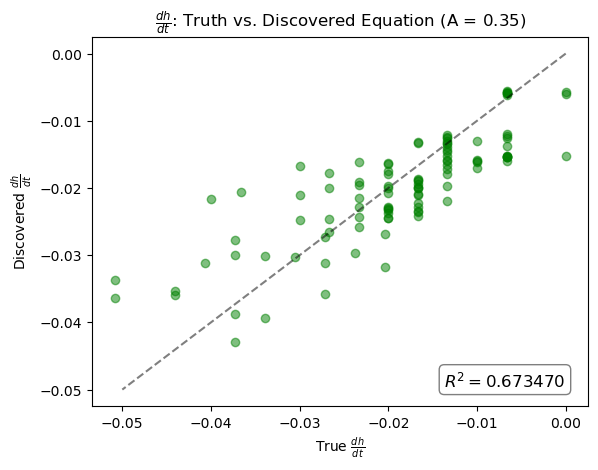

In [25]:
#plotting data
import matplotlib.pyplot as plt
import numpy as np

# Create dummy data
true_p = dh_dt
predicted_p = w_e

# Calculate the R^2 value
correlation_matrix = np.corrcoef(true_p, predicted_p)
correlation_xy = correlation_matrix[0, 1]
r_squared = correlation_xy**2

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.scatter(true_p, predicted_p, color='green', alpha=0.5)

# Plot the 1:1 line
plt.plot([0, -.05], [0, -.05], linestyle='dashed', c="k", alpha=.5)

# Add a text box for the R^2 value
textstr = f'$R^2 = {r_squared:.6f}$'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0, -0.05, textstr, fontsize=12, verticalalignment='bottom', horizontalalignment='right', bbox=props)

# Add labels and title
ax.set_xlabel('True $\\frac{{{dh}}}{{{dt}}}$')
ax.set_ylabel('Discovered $\\frac{{{dh}}}{{{dt}}}$')
ax.set_title(f"$\\frac{{{"dh"}}}{{{"dt"}}}$: Truth vs. Discovered Equation (A = {.35})")


# Show the plot
plt.show()


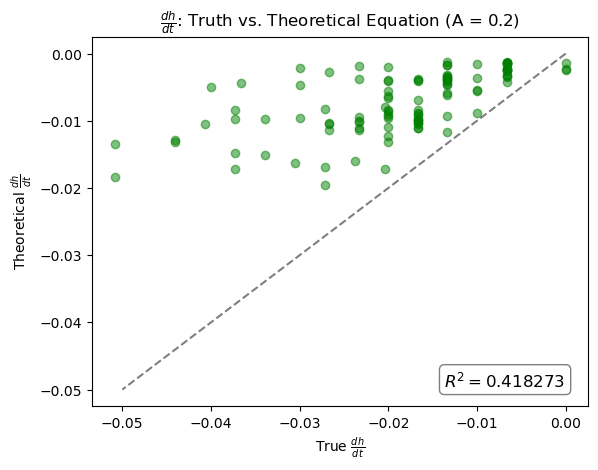

In [31]:
#plotting truth vs A=.2

import matplotlib.pyplot as plt
import numpy as np

# Create dummy data
true_p = dh_dt
predicted_p = (-6.11620795107*b_flux_del_th)

# Calculate the R^2 value
correlation_matrix = np.corrcoef(true_p, predicted_p)
correlation_xy = correlation_matrix[0, 1]
r_squared = correlation_xy**2

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.scatter(true_p, predicted_p, color='green', alpha=0.5)

# Plot the 1:1 line
plt.plot([0, -.05], [0, -.05], linestyle='dashed', c="k", alpha=.5)

# Add a text box for the R^2 value
textstr = f'$R^2 = {r_squared:.6f}$'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0, -0.05, textstr, fontsize=12, verticalalignment='bottom', horizontalalignment='right', bbox=props)

# Add labels and title
ax.set_xlabel('True $\\frac{{{dh}}}{{{dt}}}$')
ax.set_ylabel('Theoretical $\\frac{{{dh}}}{{{dt}}}$')
ax.set_title(f"$\\frac{{{"dh"}}}{{{"dt"}}}$: Truth vs. Theoretical Equation (A = {.2})")

# Add a legend


# Show the plot
plt.show()

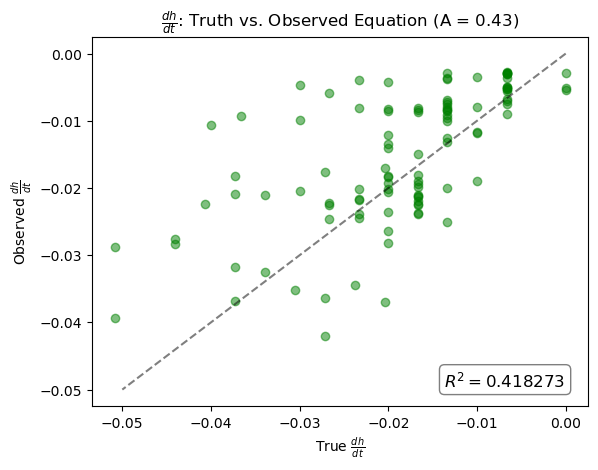

In [29]:
#plotting observational A=.43
# Create dummy data
true_p = dh_dt
predicted_p = (-13.1498470948*b_flux_del_th)

# Calculate the R^2 value
correlation_matrix = np.corrcoef(true_p, predicted_p)
correlation_xy = correlation_matrix[0, 1]
r_squared = correlation_xy**2

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.scatter(true_p, predicted_p, color='green', alpha=0.5)

# Plot the 1:1 line
plt.plot([0, -.05], [0, -.05], linestyle='dashed', c="k", alpha=.5)

# Add a text box for the R^2 value
textstr = f'$R^2 = {r_squared:.6f}$'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0, -0.05, textstr, fontsize=12, verticalalignment='bottom', horizontalalignment='right', bbox=props)

# Add labels and title
ax.set_xlabel('True $\\frac{{{dh}}}{{{dt}}}$')
ax.set_ylabel('Observed $\\frac{{{dh}}}{{{dt}}}$')
ax.set_title(f"$\\frac{{{"dh"}}}{{{"dt"}}}$: Truth vs. Observed Equation (A = {.43})")

# Add a legend


# Show the plot
plt.show()


In [34]:
saved_ed = pd.read_csv("/home/laurapong321/leap_24/LEAP_Summer24_Project2/REU_L_G/hall_of_fame_2024-09-19_083350.515.csv")
saved_ed

,Complexity,Loss,Equation
0,1,0.000114,-0.018879093
1,3,0.000104,-0.017637806 - b_flux_del_th
2,4,0.000086,b_flux_del_th / -0.07150808
3,6,0.000057,-0.009435024 - (u_g * b_flux_del_th)
4,8,0.000053,(-0.008900501 - b_flux_del_th) - (b_flux_del_t...
5,9,0.000039,(u_g / -1234.6415) - (b_flux_del_th * 10.696715)
